In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib


In [2]:
# Load preprocessed dataset
data = pd.read_csv("feature_engineered_greenpulse.csv")

print(" Dataset Loaded Successfully")
print("Shape:", data.shape)
print("Columns:", list(data.columns))


 Dataset Loaded Successfully
Shape: (5616, 37)
Columns: ['country', 'subnational1', 'threshold', 'area_ha', 'extent_2000_ha', 'extent_2010_ha', 'gain_2000-2020_ha', 'tc_loss_ha_2001', 'tc_loss_ha_2002', 'tc_loss_ha_2003', 'tc_loss_ha_2004', 'tc_loss_ha_2005', 'tc_loss_ha_2006', 'tc_loss_ha_2007', 'tc_loss_ha_2008', 'tc_loss_ha_2009', 'tc_loss_ha_2010', 'tc_loss_ha_2011', 'tc_loss_ha_2012', 'tc_loss_ha_2013', 'tc_loss_ha_2014', 'tc_loss_ha_2015', 'tc_loss_ha_2016', 'tc_loss_ha_2017', 'tc_loss_ha_2018', 'tc_loss_ha_2019', 'tc_loss_ha_2020', 'tc_loss_ha_2021', 'tc_loss_ha_2022', 'tc_loss_ha_2023', 'subnational2', 'tree_cover_loss_total', 'loss_gain_ratio', 'loss_extent_ratio', 'gain_extent_ratio', 'GDI', 'GDI_Category']


In [4]:
# Encode categorical columns
le = LabelEncoder()
for col in data.select_dtypes(include='object').columns:
    data[col] = le.fit_transform(data[col].astype(str))

# Handle missing values using KNN Imputer
imputer = KNNImputer(n_neighbors=5)
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

print(" Label encoding and missing value imputation completed.")


 Label encoding and missing value imputation completed.


In [5]:
# Ensure target column (GDI) exists
if "GDI" in data_imputed.columns:
    X = data_imputed.drop(columns=["GDI"])
    y = data_imputed["GDI"]
else:
    raise KeyError(" 'GDI' column not found in dataset!")


In [6]:
# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 4492
Testing samples: 1124


In [7]:
# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Feature scaling applied.")


 Feature scaling applied.


In [8]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42, max_depth=6)
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Cross-validation (5 folds)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2 Score": r2_score(y_test, y_pred),
        "CV Mean R2": np.mean(cv_scores)
    }

    # Save model
    joblib.dump(model, f"{name.replace(' ', '_').lower()}_model.pkl")
    print(f" Saved model: {name}")

print("\n All models trained and saved successfully.")


 Saved model: Linear Regression
 Saved model: Decision Tree

 All models trained and saved successfully.


In [9]:
# Display evaluation metrics
eval_df = pd.DataFrame(results).T
print("\n Model Evaluation Metrics:")
print(eval_df)



 Model Evaluation Metrics:
                            MAE           MSE          RMSE  R2 Score  \
Linear Regression  3.029532e-13  3.840635e-25  6.197286e-13  1.000000   
Decision Tree      1.238586e+00  1.970113e+01  4.438595e+00  0.999561   

                   CV Mean R2  
Linear Regression     1.00000  
Decision Tree         0.99232  


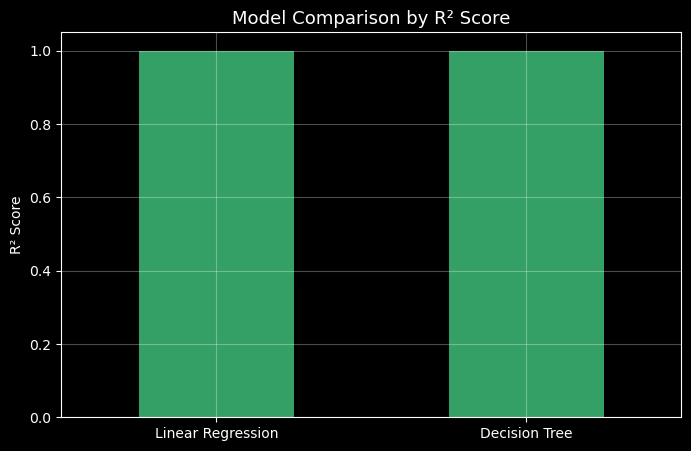

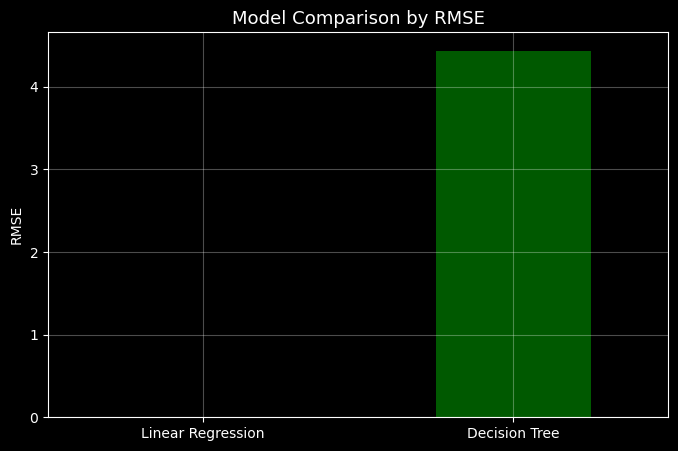

In [10]:
plt.style.use('dark_background')

# Compare R2 Scores
plt.figure(figsize=(8,5))
eval_df["R2 Score"].plot(kind='bar', color='mediumseagreen', alpha=0.9)
plt.title("Model Comparison by R² Score", fontsize=13)
plt.ylabel("R² Score")
plt.xticks(rotation=0)
plt.grid(alpha=0.3)
plt.show()

# Compare RMSE
plt.figure(figsize=(8,5))
eval_df["RMSE"].plot(kind='bar', color='darkgreen', alpha=0.9)
plt.title("Model Comparison by RMSE", fontsize=13)
plt.ylabel("RMSE")
plt.xticks(rotation=0)
plt.grid(alpha=0.3)
plt.show()


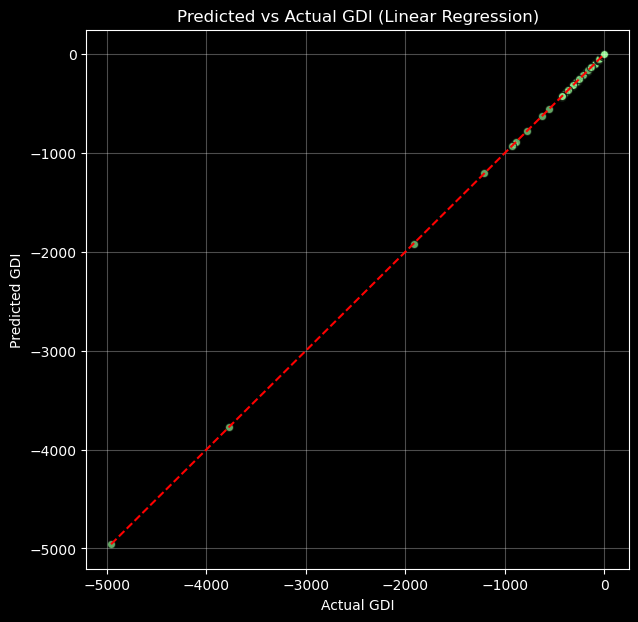

In [12]:
best_model_name = eval_df["R2 Score"].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_best, color='lightgreen', alpha=0.7, edgecolor='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f"Predicted vs Actual GDI ({best_model_name})")
plt.xlabel("Actual GDI")
plt.ylabel("Predicted GDI")
plt.grid(alpha=0.3)
plt.show()


In [13]:
eval_df.to_csv("model_evaluation_results.csv")
print(" Saved evaluation results to model_evaluation_results.csv")


 Saved evaluation results to model_evaluation_results.csv
